<a href="https://colab.research.google.com/github/kiharalab/DAQ-Refine/blob/main/DAQ_Refine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://user-images.githubusercontent.com/50850224/184964587-79a4e08d-4edd-4ef8-b69b-dfa8fe3b4804.png" align="left" style="height:240px">

#DAQ-refine: Protein Structure refinement by DAQ-score and ColabFold

This notebook contains a modified [ColabFold notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) and our tools.
To identify low quality regions in the protein structyure,
Please use [DAQ-score colab](https://colab.research.google.com/drive/1Q-Dj42QjVO8TCOLXMQBJlvm1zInxPkOu?usp=sharing)

<br><br>

##Reference: <br>
[Terashi, G., Wang, X., Maddhuri Venkata Subramaniya, S.R., Kihara, D.. Residue-wise local quality estimation for protein models from cryo-EM maps. Nat Methods 19.9 (2022). https://doi.org/10.1038/s41592-022-01574-4](https://www.nature.com/articles/s41592-022-01574-4)<br>
[Terashi, G., Wang, X., Kihara, D.. Protein model refinement for cryo-EM maps using AlphaFold2 and the DAQ
score. Acta Cryst. D79 (2022). https://doi.org/10.1107/S2059798322011676](https://doi.org/10.1107/S2059798322011676)

---
#Instructions
DAQ-refine has two strategies for the model refinement with DAQ-score.
###Before starting DAQ-refine, please use [**DAQ-score**](https://colab.research.google.com/drive/1Q-Dj42QjVO8TCOLXMQBJlvm1zInxPkOu?usp=sharing) on Google Colab, and then download a result file (**daq_score_w9.pdb**). DAQ-refine uses this **daq_score_w9.pdb** as a template structure.

##**Strategy-1: DAQ-score + ColabFold with a trimmed template model.**
You need:
*   Output file of DAQ-score (**daq_score_w9.pdb**).

##**Strategy-2: DAQ-score + ColabFold with a trimmed template model + trimmed MSAs.**
You need:
* Output file of DAQ-score (**daq_score_w9.pdb**).
* A MSA file (**A3M format**).
 * If you do not have a MSA file, please use `Vanilla AlphaFold2` or [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb).

##After the ColabFold part, Rosetta relax protocol with the EM map will improve the model quality further.
* [Rosetta relax tutorial](https://www.rosettacommons.org/docs/latest/application_documentation/structure_prediction/relax)

* [Scripts and Tutorials](https://dimaiolab.ipd.uw.edu/software/)


#STEP-0 Install Dependencies

In [ ]:
#@title Install dependency
#@markdown maxit (for converting fille format PDB to CIF)<br>
#@markdown biopython (for structure alignment visualization) <br>
#@markdown Just click `Run Cell` (the left button) or `Ctr+Enter` to run
! wget https://sw-tools.rcsb.org/apps/MAXIT/maxit-v11.100-prod-src.tar.gz
! zcat maxit-v11.100-prod-src.tar.gz | tar -xf -
#configure our environment
import urllib.request

get_url= urllib.request.urlopen('https://kiharalab.org/emsuites/daq_refine_count.php?pwd=daq_dklab')
import os
RCSBROOT=os.path.join(os.getcwd(),"maxit-v11.100-prod-src")
os.environ['RCSBROOT']=RCSBROOT
os.environ['PATH'] += ":RCSBROOT$/bin"
%cd maxit-v11.100-prod-src
! sudo apt-get install bison
! sudo apt-get install flex
! sudo apt-get install csh
! sudo apt install bash-completion
! ls binary.csh
! make binary
!csh binary.csh
!./bin/DictToSdb -ddlFile ./data/ascii/mmcif_ddl.dic -dictFile ./data/ascii/mmcif_pdbx.dic -dictSdbFile mmcif_pdbx.sdb
!mv mmcif_pdbx.sdb ./data/binary
!rm -f ./bin/DictToSdb ./bin/cif2bin ./bin/connect_main
!csh 'if [ -e ./mmcif_pdbx.dic-parser.log ]; then rm -rf ./mmcif_pdbx.dic-parser.log; fi'
import os
cur_path=os.getcwd()
script_path = os.path.join(cur_path,"bin")
script_path = os.path.join(script_path,"maxit")
os.environ["maxit"]=script_path
%cd ..
!git clone https://github.com/biopython/biopython
#!pip install biopython
%cd biopython
!pip install .
%cd ..
# running command in this notebook : !$maxit -input xx.pdb -output xx.cif -o 1 or maxit -input xx.cif -output xx.pdb -o 2

--2023-09-07 22:28:20--  https://sw-tools.rcsb.org/apps/MAXIT/maxit-v11.100-prod-src.tar.gz
Resolving sw-tools.rcsb.org (sw-tools.rcsb.org)... 128.6.150.112
Connecting to sw-tools.rcsb.org (sw-tools.rcsb.org)|128.6.150.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75123919 (72M) [application/x-gzip]
Saving to: ‘maxit-v11.100-prod-src.tar.gz’

maxit-v11.100-prod- 100%[===================>]  71.64M  13.3MB/s    in 7.0s    

2023-09-07 22:28:28 (10.2 MB/s) - ‘maxit-v11.100-prod-src.tar.gz’ saved [75123919/75123919]

/content/maxit-v11.100-prod-src
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  bison-doc
The following NEW packages will be installed:
  bison
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 748 kB of archives.
After this operation, 2,519 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 bison amd64 

<a name='step1'></a>
# STEP-1: Input Protein Sequence and DAQ result file

1. Select the DAQ-refine strategy:
* **Vanilla AlphaFold2** : does not use the DAQ-score result.
* **Strategy-1**: DAQ-score + ColabFold with a trimmed template model.
* **Strategy-2**: DAQ-score + ColabFold with a trimmed template model + trimmed MSAs.

2. **If you select Strategy-1 or -2**, upload a result file (**daq_score_w9.pdb**) generated by [DAQ-score colab](https://colab.research.google.com/drive/1Q-Dj42QjVO8TCOLXMQBJlvm1zInxPkOu?usp=sharing).

3. **If you select Strategy-2**, upload MSA file in **Input data** cell.

4. Runtime -> Run all


##Input data
<a name="template_mode"></a>

In [ ]:
#@title Input data
#@markdown Select strategy
from google.colab import files
import os
import os.path
import re
import hashlib
import random
import string

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def TrimDAQ(filename,cutoff,outfile):
    daq=[]
    PDB={}
    lines=''
    count_use=0
    with open(filename) as f:
        for li in f:
            #print(li)
            if li.startswith('ATOM'):
                li=li.strip()
                resn = int(li[22:26])
                sco = float(li[60:66])
                x = float(li[30:38])
                y = float(li[38:46])
                z = float(li[46:54])
                res_name=li[17:20]
                PDB[str(resn)]=[x,y,z,sco]
                if sco < cutoff:
                    #print(sco)
                    daq.append(resn)
                else:
                    if res_name!="UNK":
                      lines=lines+li[:21]+'A'+li[22:]+'\n'
                    else:
                      lines=lines+li[:17]+"ALA A"+li[22:]+'\n'
                    count_use+=1
    if count_use<=0:
      print("All regions are detected Wrong by DAQ! DAQ-Refine can not work!")
      raise Exception("All regions are detected Wrong by DAQ! DAQ-Refine can not work!")

    #print(lines)
    with open(outfile,'w') as out:
        out.write(lines)

rand_letters = string.ascii_lowercase
rand_letters = ''.join(random.choice(rand_letters) for i in range(20))
daq_file=''
str_mode = "strategy2" #@param ["Vanilla AF2","strategy1","strategy2"]
if str_mode == "strategy1" or str_mode == "strategy2":
  root_dir = os.getcwd()
  upload_dir = os.path.join(root_dir,rand_letters)
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  os.chdir(upload_dir)
  print("Please Upload daq_score_w9.pdb (DAQ-score output file) HERE")
  pdb_input = files.upload()

  for fn in pdb_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(pdb_input[fn])))
    pdb_input_path = os.path.abspath(fn)
    print("PDB save to %s"%pdb_input_path)
    TrimDAQ(pdb_input_path,0.0,upload_dir+'/1tmp.pdb')
    #files.download(upload_dir+'/1tmp.pdb')
    #convert PDB to CIF
    !$maxit -input 1tmp.pdb -output 1tmp.cif -o 1
    #files.download(upload_dir+'/1tmp.cif')
    daq_file=upload_dir+'/1tmp.cif'
  os.chdir(root_dir)


#@title Prepare a trimmed template model

##Use Colab Fold Part
from google.colab import files
import os.path
import re
import hashlib
import random

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

#@markdown Input target sequence
query_sequence = 'MGEVTAEEVEKFLDSNVSFAKQYYNLRYRAKVISDLLGPREAAVDFSNYHALNSVEESEIIFDLLRDFQDNLQAEKCVFNVMKKLCFLLQADRMSLFMYRARNGIAELATRLFNVHKDAVLEECLVAPDSEIVFPLDMGVVGHVALSKKIVNVPNTEEDEHFCDFVDTLTEYQTKNILASPIMNGKDVVAIIMVVNKVDGPHFTENDEEILLKYLNFANLIMKVFHLSYLHNCETRRGQILLWSGSKVFEELTDIERQFHKALYTVRAFLNCDRYSVGLLDMTKQKEFFDVWPVLMGEAPPYAGPRTPDGREINFYKVIDYILHGKEDIKVIPNPPPDHWALVSGLPTYVAQNGLICNIMNAPSEDFFAFQKEPLDESGWMIKNVLSMPIVNKKEEIVGVATFYNRKDGKPFDEMDETLMESLTQFLGWSVLNPDTYELMNKLENRKDIFQDMVKYHVKCDNEEIQTILKTREVYGKEPWECEEEELAEILQGELPDADKYEINKFHFSDLPLTELELVKCGIQMYYELKVVDKFHIPQEALVRFMYSLSKGYRRITYHNWRHGFNVGQTMFSLLVTGKLKRYFTDLEALAMVTAAFCHDIDHRGTNNLYQMKSQNPLAKLHGSSILERHHLEFGKTLLRDESLNIFQNLNRRQHEHAIHMMDIAIIATDLALYFKKRTMFQKIVDQSKTYETQQEWTQYMMLDQTRKEIVMAMMMTACDLSAITKPWEVQSKVALLVAAEFWEQGDLERTVLQQNPIPMMDRNKADELPKLQVGFIDFVCTFVYKEFSRFHEEITPMLDGITNNRKEWKALADEYETKMKGLEEEKQKQQAANQAAAGSQHGGKQPGGGPASKSCCVQ' #@param {type:"string"}

# remove whitespaces
query_sequence = "".join(query_sequence.split())

jobname = '7jsn1_sg2' #@param {type:"string"}
# remove whitespaces
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)
while os.path.isfile(f"{jobname}.csv"):
  jobname = add_hash(basejobname, ''.join(random.sample(query_sequence,len(query_sequence))))

with open(f"{jobname}.csv", "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

queries_path=f"{jobname}.csv"

# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
use_amber = num_relax > 0
#use_amber = False #@param {type:"boolean"}
template_mode = "none" #@param ["none", "pdb70","custom"]
#@markdown - This option is only active for Vanilla AF mode.
#@markdown - "none" = no template information is used, "pdb70" = detect templates in pdb70, "custom" - upload and search own templates (PDB or mmCIF format, see [notes below](#custom_templates))


if str_mode == "strategy1" or str_mode == "strategy2":
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  #uploaded = files.upload()
  use_templates = True
  #for fn in uploaded.keys():
  fn = daq_file
  os.rename(fn, f"{jobname}_template/1tmp.cif")
  template_mode = "custom"
elif template_mode == "pdb70":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = f"{jobname}_template"
  os.mkdir(custom_template_path)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn, f"{jobname}_template/{fn}")
else:
  custom_template_path = None
  use_templates = False

##MSA part##
def trim_a3m(a3m,daq,good):
    out=[]
    for ith in range(len(a3m)):
        name,seq = a3m[ith]
        new_seq=''
        if ith == 0:#query
            new_seq = seq
        else:
            pos=0
            for aa in seq:
                if aa == aa.lower() and aa != '-':
                    continue
                pos = pos + 1
                if pos in daq: #selected bad regions or missing regions
                    new_seq = new_seq + aa
                elif not pos in good:
                    new_seq = new_seq + aa
                elif aa == aa.upper():
                    new_seq = new_seq + '-'
        out.append([name,new_seq])
    return out

def ReadA3M(filename):
    A3M=[]
    with open(filename) as f:
        for li in f:
            if li.startswith('#'):
                continue
            if li.startswith('>'):
                name = li.strip()
            else:
                seq = li.strip()
                A3M.append([name,seq])
    return A3M

def ReadDAQ(filename,cutoff,dist_cut):
    daq=[]
    PDB={}
    with open(filename) as f:
        for li in f:
            #print(li)
            if li.startswith('ATOM') and li[13:16]=='CA ':
                li=li.strip()
                resn = int(li[23:27])
                sco = float(li[60:66])
                x = float(li[30:38])
                y = float(li[38:46])
                z = float(li[46:54])
                PDB[str(resn)]=[x,y,z,sco]
                if sco < cutoff:
                    #print(sco)
                    daq.append(resn)
    print(daq)
    daq2=[]
    for resn in PDB:
        if int(resn) in daq:
            continue
        #Distance check
        x1=PDB[resn][0]
        y1=PDB[resn][1]
        z1=PDB[resn][2]
        for resn2 in PDB:
            if not int(resn2) in daq:
                continue
            x2=PDB[resn2][0]
            y2=PDB[resn2][1]
            z2=PDB[resn2][2]
            dist=(x1-x2)*(x1-x2)+(y1-y2)*(y1-y2)+(z1-z2)*(z1-z2)
            if dist <=dist_cut*dist_cut:#close
                daq2.append(int(resn))
                break
    #print('LowDAQ',daq,'Extended',daq2)
    daq=list(set(daq+daq2))
    #Others
    goodpos=[]
    for resn in PDB:
        if int(resn) in daq:
            continue
        goodpos.append(int(resn))
    print('HighDAQ',goodpos)

    return daq,goodpos

def save_a3m(file,a3m):
    lines=''
    for name,seq in a3m:
        lines = lines + name+'\n'
        lines = lines + seq+'\n'
    with open(file,'w') as out:
        out.write(lines)

#Use MSA
if str_mode == "strategy2":
  root_dir = os.getcwd()
  print(root_dir)
  print('Please upload MSA file (a3m format)')
  upload_dir = os.path.join(root_dir,rand_letters)
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  os.chdir(upload_dir)
  cust_msa_input = files.upload()

  if not os.path.isfile(pdb_input_path):
    print('Can not find DAQ-score output file!!')


  for fn in cust_msa_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(cust_msa_input[fn])))
    cust_msa_path = os.path.abspath(fn)
    print("MSA save to %s"%cust_msa_path)
    a3m=ReadA3M(cust_msa_path)
    daq,good=ReadDAQ(pdb_input_path,0.0,0.0)
    new_a3m=trim_a3m(a3m,daq,good)
    filename=upload_dir+'/trimmed_msa.a3m'
    save_a3m(filename,new_a3m)
    daq_msa = filename
    #files.download(filename)
  os.chdir(root_dir)

Please Upload daq_score_w9.pdb (DAQ-score output file) HERE


Saving dqa_score_w9.pdb to dqa_score_w9.pdb
User uploaded file "dqa_score_w9.pdb" with length 883462 bytes
PDB save to /content/tdayizqmbmnaqpytuemw/dqa_score_w9.pdb
/content
Please upload MSA file (a3m format)


Saving 7jsn1_193ac.a3m to 7jsn1_193ac.a3m
User uploaded file "7jsn1_193ac.a3m" with length 6896169 bytes
MSA save to /content/tdayizqmbmnaqpytuemw/7jsn1_193ac.a3m
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 372, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 

<a name='step2'></a>
#STEP-2: Modeling Part (by ColabFold)


### MSA options (custom MSA upload)
<a name="msa_options"></a>

In [ ]:

#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.



# decide which a3m to use
if str_mode == "strategy2":
  msa_mode = "custom"
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    #custom_msa_dict = files.upload()
    #custom_msa = list(custom_msa_dict.keys())[0]
    custom_msa = daq_msa
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
elif msa_mode.startswith("mmseqs2"):
  a3m_file = f"{jobname}.a3m"
elif msa_mode == "custom":
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

moving /content/tdayizqmbmnaqpytuemw/trimmed_msa.a3m to 7jsn1_sg2_52a09.custom.a3m


## Advanced setting and Install dependencies

In [ ]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "1" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.



In [ ]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/kiharalab/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")


installing colabfold...
installing conda...
installing hhsuite...
CPU times: user 288 ms, sys: 39.2 ms, total: 327 ms
Wall time: 1min 22s


##Run Prediction
Ctr + Enter

2023-09-07 22:42:47,203 Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
2023-09-07 22:42:47,204 Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-09-07 22:42:49,116 Running on GPU
2023-09-07 22:42:49,210 Found 4 citations for tools or databases
2023-09-07 22:42:49,465 Adding missing field revision_date to 7jsn1_sg2_52a09_template/1tmp.cif. Backing up original file to 7jsn1_sg2_52a09_template/1tmp.cif.bak.
2023-09-07 22:42:49,990 Query 1/1: 7jsn1_sg2_52a09.custom (length 859)
2023-09-07 22:42:53,441 Sequence 0 found templates: ['1tmp_A', '1tmp_A', '1tmp_A', '1tmp_A']


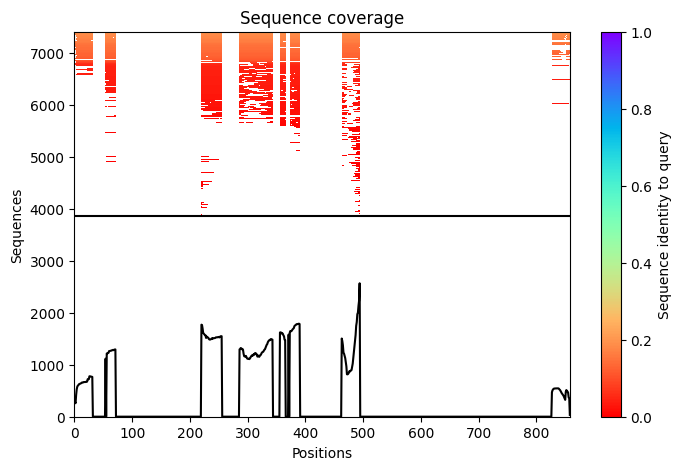

2023-09-07 22:42:55,880 Setting max_seq=512, max_extra_seq=5120
2023-09-07 22:47:28,384 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=82.4 pTM=0.64
2023-09-07 22:51:16,629 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=82.6 pTM=0.622 tol=0.999
2023-09-07 22:51:16,630 alphafold2_ptm_model_1_seed_000 took 485.1s (1 recycles)


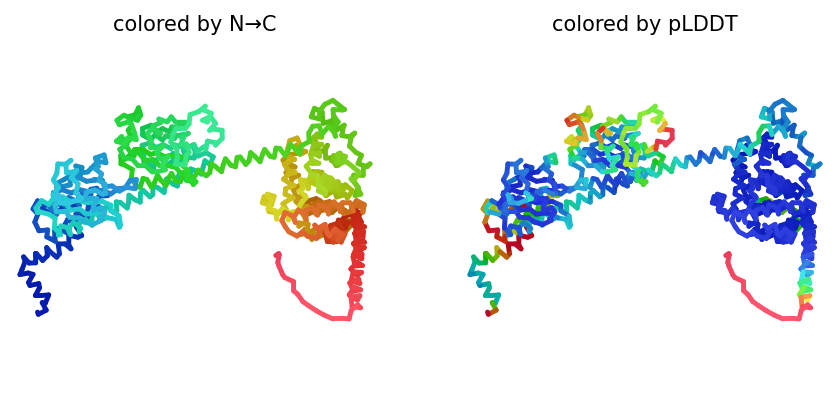

2023-09-07 22:55:05,735 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=83.4 pTM=0.717
2023-09-07 22:58:53,943 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=83.1 pTM=0.679 tol=2.55
2023-09-07 22:58:53,945 alphafold2_ptm_model_2_seed_000 took 456.1s (1 recycles)


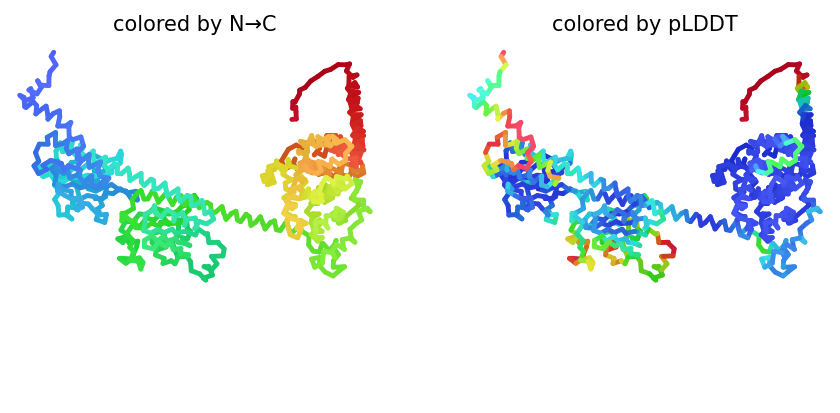

2023-09-07 23:02:42,591 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=41.8 pTM=0.293
2023-09-07 23:06:16,137 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=43.6 pTM=0.292 tol=13.9
2023-09-07 23:06:16,139 alphafold2_ptm_model_3_seed_000 took 440.9s (1 recycles)


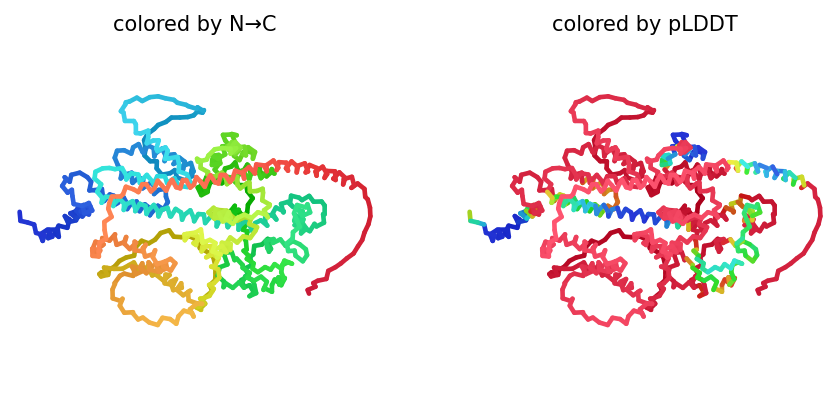

2023-09-07 23:09:50,683 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=36.5 pTM=0.239
2023-09-07 23:13:24,352 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=36.8 pTM=0.232 tol=11.6
2023-09-07 23:13:24,354 alphafold2_ptm_model_4_seed_000 took 427.1s (1 recycles)


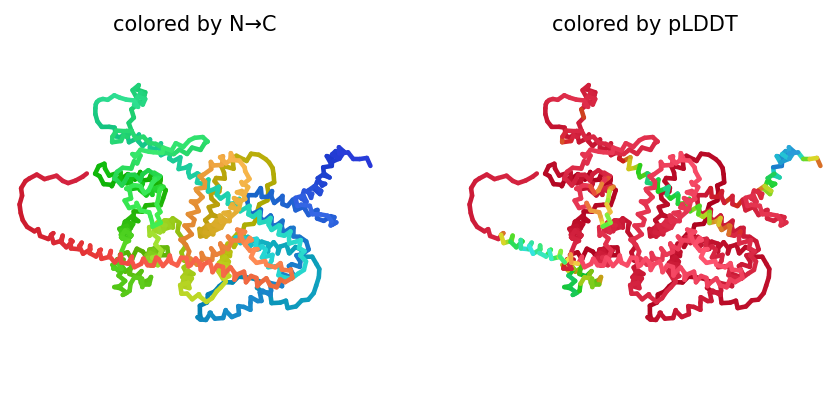

2023-09-07 23:16:58,813 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=43 pTM=0.313
2023-09-07 23:20:32,365 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=45.5 pTM=0.353 tol=16.2
2023-09-07 23:20:32,367 alphafold2_ptm_model_5_seed_000 took 426.8s (1 recycles)


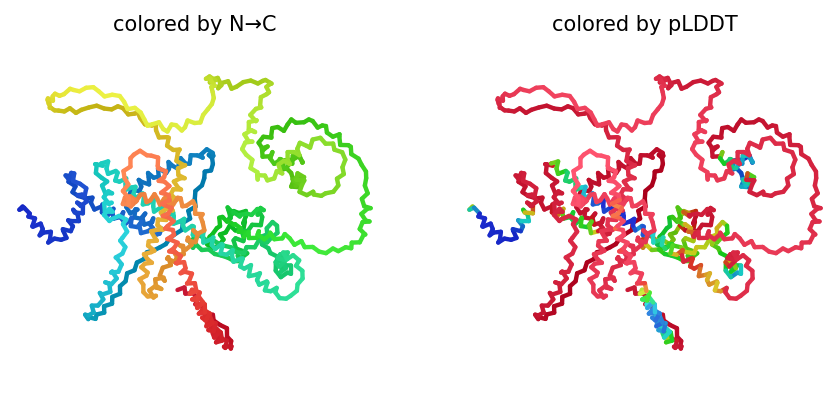

2023-09-07 23:20:33,841 reranking models by 'plddt' metric
2023-09-07 23:20:33,843 rank_001_alphafold2_ptm_model_2_seed_000 pLDDT=83.1 pTM=0.679
2023-09-07 23:20:33,843 rank_002_alphafold2_ptm_model_1_seed_000 pLDDT=82.6 pTM=0.622
2023-09-07 23:20:33,843 rank_003_alphafold2_ptm_model_5_seed_000 pLDDT=45.5 pTM=0.353
2023-09-07 23:20:33,844 rank_004_alphafold2_ptm_model_3_seed_000 pLDDT=43.6 pTM=0.292
2023-09-07 23:20:33,844 rank_005_alphafold2_ptm_model_4_seed_000 pLDDT=36.8 pTM=0.232
2023-09-07 23:20:37,502 Done


0

In [ ]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

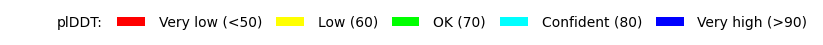

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


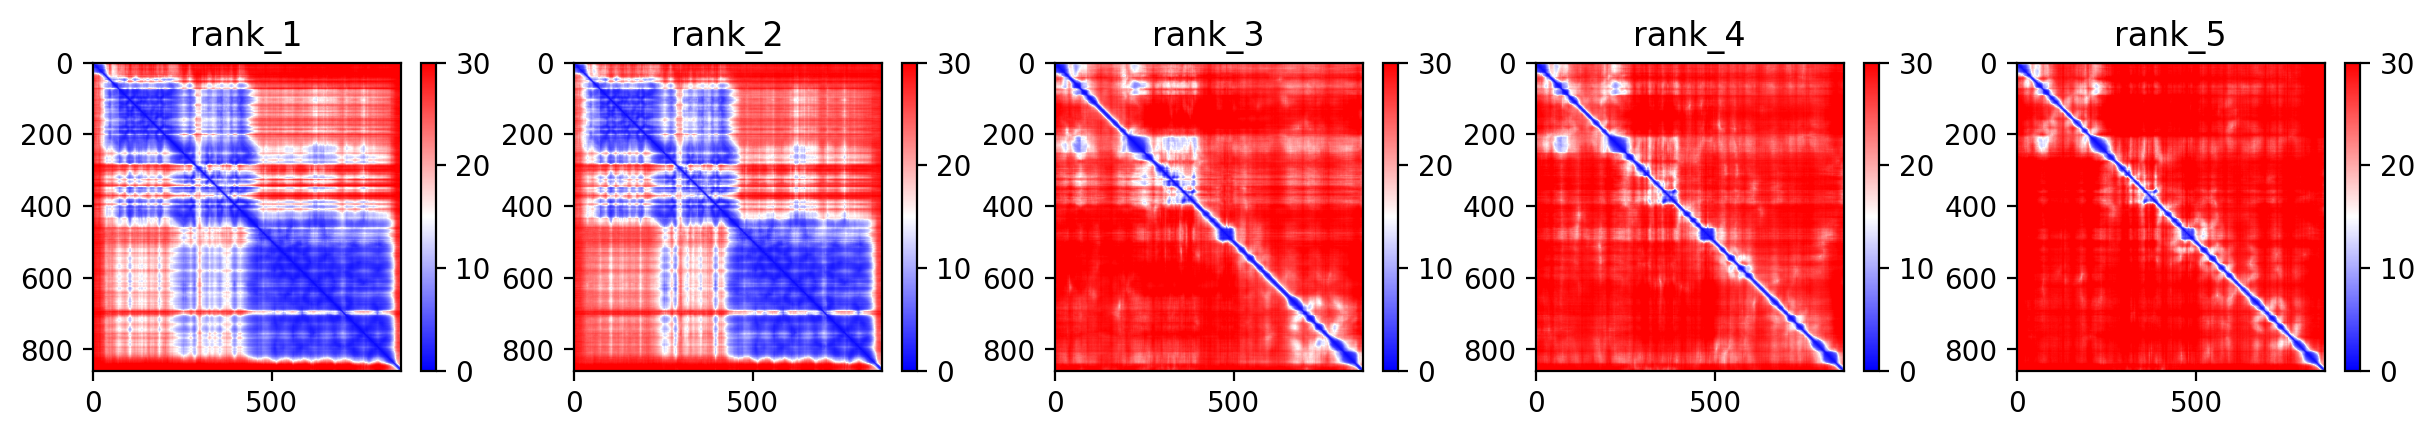
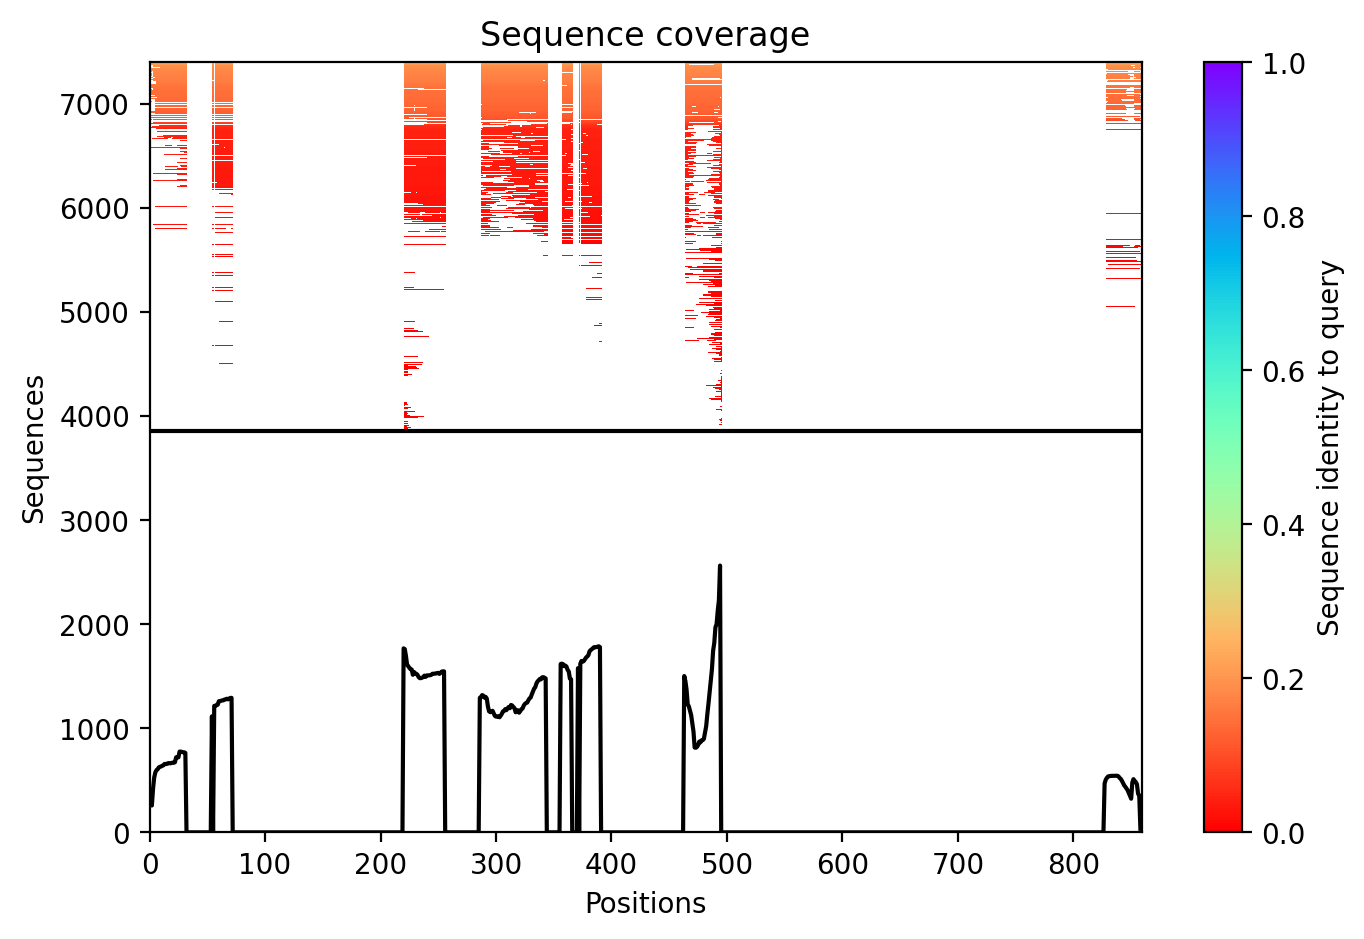
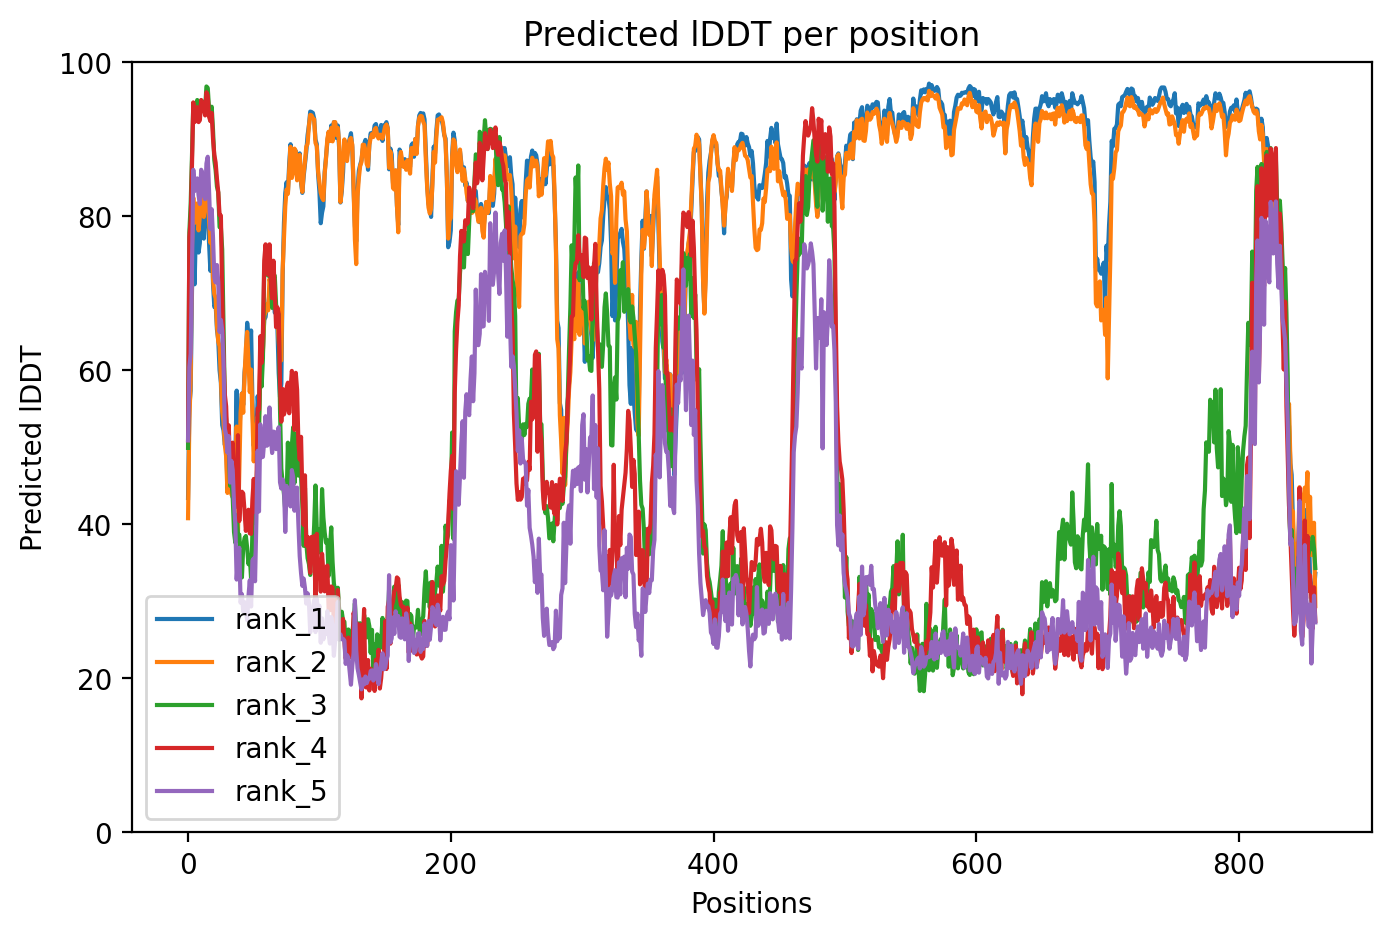

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

!zip -FSr $jobname".result.zip" config.json $jobname*".json" $jobname*".a3m" $jobname*"relaxed_rank_"*".pdb" "cite.bibtex" $jobname*".png"
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

Don't forget to cite your custom MSA generation method.
	zip warning: name not matched: config.json
	zip warning: name not matched: cite.bibtex
deleting: 7jsn1_sg2_52a09/
deleting: 7jsn1_sg2_52a09/cite.bibtex
deleting: 7jsn1_sg2_52a09/7jsn1_sg2_52a09.custom.a3m
deleting: 7jsn1_sg2_52a09/log.txt
deleting: 7jsn1_sg2_52a09/7jsn1_sg2_52a09.custom.done.txt
  adding: 7jsn1_sg2_52a09.custom.a3m (deflated 95%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# References
```
@article{genki2022DAQ,   
  title={Residue-Wise Local Quality Estimation for Protein Models from Cryo-EM Maps},   
  author={Genki Terashi, Xiao Wang, Sai Raghavendra Maddhuri Venkata Subramaniya, John J. G. Tesmer, and Daisuke Kihara},    
  journal={Nature Methods},    
  year={2022}    
}   
```
```
@article{genki2022daqrefine,   
  title={Protein model refinement for cryo-EM maps using AlphaFold2 and the DAQ score},   
  author={Genki Terashi, Xiao Wang, and Daisuke Kihara},    
  journal={Acta Cryst},    
  year={2022}    
}   
```

# Instructions <a name="Instructions"></a>
**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Detail Instructions of ColabFold part
- Please check [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)

**License**
The source code of DAQ-score and DAQ-refine are licensed under GPL v3. (If you are interested in a different license, for example, for commercial use, please contact [us](dkihara@purdue.edu).)

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

